# Analyzing inertial parameter estimation in simulation
## Read Text file and make variables

In [4]:
#!/usr/bin/env python3

# read text files

import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import signal, fftpack
from scipy.signal import savgol_filter
%matplotlib inline

# enter data file here

data_file = "data_file_04-09-19_10-16-03"
# info about data_file_03-14-19_12-55-13
# RLS controller drawing circles
# correct estimation m,com, wrong inertia
# gravity included

# info about data_file_03-14-19_15-17-59
# Trajectory testing with sin yaxis
# gravity included
# wrong estimation m,com,inertia T

# info about data_file_03-14-19_15-21-49
# RLS controller with sin yaxis
# gravity removed
# right estimation m, wrong com,inertia

# info about data_file_03-14-19_16-12-11
# RLS controller with sin yaxis + move up and down
# gravity removed
# right estimation m,com wrong inertia

# info about data_file_03-14-19_20-57-06
# estimation controller with sin yaxis + move up and down
# gravity removed
# right estimation m,com wrong inertia


path = "/Users/elenakern/university/masters/sai-2/apps/inertial_parameter_application/data_collection/simulation/inertial_params_est/"

# path = "/home/elenakern/Codes/sai2.0/applications/data_collection/simulation/inertial_params_est/"
path_data_file = path + data_file

file = np.loadtxt(path_data_file,skiprows=1)

pos             = file[0::,0:3]     #position (end-effector in last link frame)
vel             = file[0::,3:6]     #linear velocity (end-effector in last link frame)
accel           = file[0::,6:9]     #linear acceleration (end-effector in last link frame)
ori             = file[0::,9:13]    #orientation in quaternions (end-effector in last link frame)
avel            = file[0::,13:16]   #angular velocity (end-effector in last link frame)
aaccel          = file[0::,16:19]   #angular acceleration (end-effector in last link frame)
force_virtual   = file[0::,19:22]   #virtual force simulation
torque_virtual  = file[0::,22:25]   #virtual torque simulation
phi_RLS         = file[0::,25:35]   #inertial parameters RLS
q   = file[0::,35:42]   #virtual force simulation
dq  = file[0::,42:49]   #virtual torque simulation
q_des = file [0::,49:53]
dq_des = file [0::,53:57]
gravity = file [0::, 57:60]
accel_aff = file[0::, 60: 63]
avel_aff = file [0::, 63 : 66]
aaccel_aff = file [0::, 66:69]
gravity_aff = file [0::, 69:72]


# phi_LS          = file[0::,35:45]   #inertial parameters LS
# phi_debug       = file[0::,45:55]   #inertial parameters direct functs


#files until data_file_03-14-19_20-57-06
# accel           = file[0::,0:3]     #linear acceleration (end-effector in last link frame)
# avel            = file[0::,3:6]     #angular velocity (end-effector in last link frame)
# aaccel          = file[0::,6:9]     #angular acceleration (end-effector in last link frame)
# g_local         = file[0::,9:12]    #gravity vector (end-effector in last link frame)
# force_virtual   = file[0::,12:15]   #virtual force simulation
# torque_virtual  = file[0::,15:18]   #virtual torque simulation
# phi             = file[0::,18:28]   #inertial parameters
# mass            = file[0::,18:19]   #estimated mass
# center_of_mass  = file[0::,19:22]   #estimated center of mass
# inertial_tensor = file[0::,22:28]   #estimated inertia tensor

time = np.arange(np.size(accel[:,0]))
time = time/500




phi_aux = phi_RLS
phi_aux[:,1] /= phi_aux[:,0]
phi_aux[:,2] /= phi_aux[:,0]
phi_aux[:,3] /= phi_aux[:,0]

print(np.shape(phi_RLS[:,0]))
print(np.size(phi_RLS[:,0]))

aux = np.ones(np.shape(phi_RLS[:,0]))
mse_1 = np.empty_like(phi_RLS)
mse_2 = np.empty_like(phi_RLS)
mse_1[:,0] = (np.square(phi_RLS[:,0] - 2.0*aux)).mean(axis=0)
print(mse_1[:,0])
mse_1[0,0] = (np.square(phi_RLS[0,0] - 2.0)).mean(axis=None)
print(mse_1[:,0])
print(np.square(phi_RLS[0,0]-2.0).mean())

real_values = np.array([2.0,0.02, 0.03, 0.2, 0.5, 0.0,0.0,0.5,0.0,0.5])
for idx,value in enumerate(real_values):                           #for all 10 inertial params  
    for i in np.arange(np.size(phi_RLS[:,0])):                       #elementwise 
        mse_2[i,idx] = (np.square(phi_RLS[i,idx] - value)).mean(axis=None) #mean squared error
print(mse_2[:,0])

print(phi_RLS[:,0])



(20511,)
20511
[0.46323968 0.46323968 0.46323968 ... 0.46323968 0.46323968 0.46323968]
[0.48907644 0.46323968 0.46323968 ... 0.46323968 0.46323968 0.46323968]
0.4890764356000001
[0.48907644 0.48907644 0.48907644 ... 0.45720587 0.45721939 0.45721939]
[1.30066 1.30066 1.30066 ... 1.32383 1.32382 1.32382]


In [3]:
file.shape

(20511, 72)

## Plotting functions
### TUM colors

In [2]:
#TUM colors rgb
blue = (0,0.3961,0.7412)
red = (0.7686,0.0275,0.1059)
green =(0,0.4863,0.1882)
orange =  (0.8902, 0.4471, 0.1333)
purple = (0.4118, 0.0314, 0.3529)
grey = (0.6118, 0.6157, 0.6235)
yellow = (0.9765, 0.7294, 0)
color_list = [blue, red, green, orange, grey, purple, yellow]



### Function definitions

In [3]:
def Plot_three_dim(time, data, ylabel, title, subtitle):
    f, axarr = plt.subplots(3,1,figsize=(7,9))
    f.suptitle(title, fontsize=20)
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,coordinate in enumerate(coordinates):
        axarr[idx].plot(time, data[:,idx], c=blue)
        axarr[idx].set_title(subtitle+str(coordinate))
        axarr[idx].set_xlim([0, time[-1]])
        axarr[idx].set_ylabel(ylabel)
    axarr[2].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_intertial_params_one(time, data,estimation_approach):
    f, axarr = plt.subplots(10,1,figsize=(6,15))
    f.suptitle("Inertial Parameter Estimation " + estimation_approach, fontsize=20)
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    data[:,1] /= data[:,0]
    data[:,2] /= data[:,0]
    data[:,3] /= data[:,0]
    for idx, param in enumerate(params):
        axarr[idx].plot(time, data[:,idx], c=blue)
        axarr[idx].set_title(param)
        axarr[idx].set_xlim([0, time[-1]])
    axarr[9].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_intertial_params_one_error(time, data,estimation_approach,  m, com_x, com_y, com_z, I_xx, I_xy,I_xz, I_yy, I_yz, I_zz):
    f, axarr = plt.subplots(10,1,figsize=(6,15))
    f.suptitle("Inertial Parameter Estimation error " + estimation_approach, fontsize=20)
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    data[:,1] /= data[:,0]
    data[:,2] /= data[:,0]
    data[:,3] /= data[:,0]
    mse = np.empty_like(data)
    real_values = np.array([m, com_x,com_y,com_z, I_xx,I_xy,I_xz,I_yy,I_yz,I_zz])
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data[:,0])):                       #elementwise 
            mse[i,idx] = (np.square(data[i,idx] - value)).mean(axis=None)
    for idx, param in enumerate(params):
        axarr[idx].plot(time, mse[:,idx], c=blue)
        axarr[idx].set_title(param)
        axarr[idx].set_xlim([0, time[-1]])
    axarr[9].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_intertial_params_two(time, data_1,estimation_approach_1, data_2,estimation_approach_2):
    f, axarr = plt.subplots(10,2,figsize=(10,15))
    f.suptitle("Inertial Parameter Estimation ", fontsize=20)
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    data_1[:,1] /= data_1[:,0]
    data_1[:,2] /= data_1[:,0]
    data_1[:,3] /= data_1[:,0]
    data_2[:,1] /= data_2[:,0]
    data_2[:,2] /= data_2[:,0]
    data_2[:,3] /= data_2[:,0]
    for idx, param in enumerate(params):
        axarr[idx,0].plot(time, data_1[:,idx], c=blue)
        axarr[idx,0].set_title(param)
        axarr[idx,0].set_xlim([0, time[-1]])
    
    for idx, param in enumerate(params):
        axarr[idx,1].plot(time, data_2[:,idx], c=red)
        axarr[idx,1].set_title(param)
        axarr[idx,1].set_xlim([0, time[-1]])
    axarr[0,0].set_title(estimation_approach_1)
    axarr[9,0].set_xlabel("Elapsed time in $s$")
    axarr[0,1].set_title(estimation_approach_2)
    axarr[9,1].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_intertial_params_three(time, data_1,estimation_approach_1, data_2,estimation_approach_2, data_3,estimation_approach_3):
    f, axarr = plt.subplots(10,3,figsize=(15,15))
    f.suptitle("Inertial Parameter Estimation ", fontsize=20)
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    data_1[:,1] /= data_1[:,0]
    data_1[:,2] /= data_1[:,0]
    data_1[:,3] /= data_1[:,0]
    data_2[:,1] /= data_2[:,0]
    data_2[:,2] /= data_2[:,0]
    data_2[:,3] /= data_2[:,0]
    data_3[:,1] /= data_3[:,0]
    data_3[:,2] /= data_3[:,0]
    data_3[:,3] /= data_3[:,0]
    for idx, param in enumerate(params):
        axarr[idx,0].plot(time, data_1[:,idx], c=blue, label = estimation_approach_1)
        axarr[0,0].legend()
        axarr[idx,0].set_title(param)
        axarr[idx,0].set_xlim([0, time[-1]])
    for idx, param in enumerate(params):
        axarr[idx,1].plot(time, data_2[:,idx], c=red, label = estimation_approach_2)
        axarr[0,1].legend()
        axarr[idx,1].set_title(param)
        axarr[idx,1].set_xlim([0, time[-1]])
    for idx, param in enumerate(params):
        axarr[idx,2].plot(time, data_3[:,idx], c=green ,label = estimation_approach_3)
        axarr[0,2].legend()
        axarr[idx,2].set_title(param)
        axarr[idx,2].set_xlim([0, time[-1]])
    axarr[9,0].set_xlabel("Elapsed time in $s$")
    axarr[9,1].set_xlabel("Elapsed time in $s$")
    axarr[9,2].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    

def Plot_intertial_params_three_errors(time, data_1,estimation_approach_1, data_2,estimation_approach_2, data_3,estimation_approach_3, m, com_x, com_y, com_z, I_xx, I_xy,I_xz, I_yy, I_yz, I_zz):
    f, axarr = plt.subplots(10,3,figsize=(15,15))
    f.suptitle("Inertial Parameter Estimation error", fontsize=20)
    params = ['Mass error', 'COM_x error','COM_y error', 'COM_z error', '$I_{xx}$ error','$I_{xy}$ error', '$I_{xz}$ error','$I_{yy}$ error','$I_{yz}$ error','$I_{zz}$ error']
    data_1[:,1] /= data_1[:,0]
    data_1[:,2] /= data_1[:,0]
    data_1[:,3] /= data_1[:,0]
    data_2[:,1] /= data_2[:,0]
    data_2[:,2] /= data_2[:,0]
    data_2[:,3] /= data_2[:,0]
    data_3[:,1] /= data_3[:,0]
    data_3[:,2] /= data_3[:,0]
    data_3[:,3] /= data_3[:,0]
    
    mse_1 = np.empty_like(data_1)
    mse_2 = np.empty_like(data_1)
    mse_3 = np.empty_like(data_1)
    
    real_values = np.array([m, com_x,com_y,com_z, I_xx,I_xy,I_xz,I_yy,I_yz,I_zz])
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data_1[:,0])):                       #elementwise 
            mse_1[i,idx] = (np.square(data_1[i,idx] - value)).mean(axis=None)
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data_2[:,0])):                       #elementwise 
            mse_2[i,idx] = (np.square(data_2[i,idx] - value)).mean(axis=None)
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data_3[:,0])):                       #elementwise 
            mse_3[i,idx] = (np.square(data_3[i,idx] - value)).mean(axis=None)
    
            

    for idx, param in enumerate(params):
        axarr[idx,0].plot(time, mse_1[:,idx], c=blue, label = estimation_approach_1)
        axarr[0,0].legend()
        axarr[idx,0].set_title(param)
        axarr[idx,0].set_xlim([0, time[-1]])
    for idx, param in enumerate(params):
        axarr[idx,1].plot(time, mse_2[:,idx], c=red, label = estimation_approach_2)
        axarr[0,1].legend()
        axarr[idx,1].set_title(param)
        axarr[idx,1].set_xlim([0, time[-1]])
    for idx, param in enumerate(params):
        axarr[idx,2].plot(time, mse_3[:,idx], c=green ,label = estimation_approach_3)
        axarr[0,2].legend()
        axarr[idx,2].set_title(param)
        axarr[idx,2].set_xlim([0, time[-1]])
    axarr[9,0].set_xlabel("Elapsed time in $s$")
    axarr[9,1].set_xlabel("Elapsed time in $s$")
    axarr[9,2].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
  
    
def Plot_one_dim(time, data, ylabel, title):
    plt.plot(time, data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Elapsed time in $s$")
    
def Plot_quaternions(time, quaternions):
    w = quaternions[:,0]
    x = quaternions[:,1]
    y = quaternions[:,2]
    z = quaternions[:,3]
    f, axarr = plt.subplots(2,2,figsize=(9,9))
    f.suptitle("Orientation represented as Unit Quaternions" , fontsize=20)
    axarr[0,0].plot(time, w, c=blue)
    axarr[0,0].set_title("$q_w$")
    axarr[0,0].set_xlim([0, time[-1]])
    axarr[0,1].plot(time, x, c=blue)
    axarr[0,1].set_title("$q_x$")
    axarr[0,1].set_xlim([0, time[-1]])
    axarr[1,0].plot(time, y, c=blue)
    axarr[1,0].set_title("$q_y$")
    axarr[1,0].set_xlim([0, time[-1]])
    axarr[1,0].set_xlabel("Elapsed time in s")
    axarr[1,1].plot(time, z, c=blue)
    axarr[1,1].set_title("$q_z$")
    axarr[1,1].set_xlim([0, time[-1]])
    axarr[1,1].set_xlabel("Elapsed time in s")
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    
def Plot_kinematics_linear(time, data_1, data_2, data_3, title):
    f, axarr = plt.subplots(3,3,figsize=(15,15))
    f.suptitle(title, fontsize=20)
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,coordinate in enumerate(coordinates):
        axarr[idx,0].plot(time, data_1[:,idx], c=color_list[idx])
        axarr[idx,0].set_xlim([0, time[-1]])
        axarr[idx,0].set_ylabel("$r$"+str(coordinate)+" in " "$m$")
    for idx,coordinate in enumerate(coordinates):
        axarr[idx,1].plot(time, data_2[:,idx], c=color_list[idx])
        axarr[idx,1].set_xlim([0, time[-1]])
        axarr[idx,1].set_ylabel("$v$"+str(coordinate)+" in " r"$\frac{m}{s}$")
    for idx,coordinate in enumerate(coordinates):
        axarr[idx,2].plot(time, data_3[:,idx], c=color_list[idx])
        axarr[idx,2].set_xlim([0, time[-1]])
        axarr[idx,2].set_ylabel("$a$"+str(coordinate)+" in " r"$\frac{m}{s^2}$")
    for idx in np.arange(3):
        axarr[2,idx].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_kinematics_angular_three_plots(time, quaternions, angular_velocity, angular_acceleration, title):
    kinematics_angular = np.concatenate([angular_velocity, angular_acceleration], axis=1)
    f, axarr = plt.subplots(1,3,figsize=(20,10))
    f.suptitle(title, fontsize=20)
    color_list_aux = [ grey, blue, red, green]
    coordinates = ["$_x$","$_y$","$_z$"]
    quaternion_labels = ["$q_w$", "$q_x$", "$q_y$","$q_z$"]
    variables = [r"$\omega$", r"$\alpha$"]
    units = [r"$\frac{rad}{s}$", r"$\frac{rad}{s^2}$"]
    for idx, q_label in enumerate(quaternion_labels):
        axarr[0].plot(time, quaternions[:, idx], c = color_list_aux[idx], label = q_label)
        axarr[0].set_xlim([0, time[-1]])
        axarr[0].legend()
        axarr[0].set_xlabel("Elapsed time in $s$")
    for j, (variable,unit) in enumerate(zip(variables,units)):
        for idx,coordinate in enumerate(coordinates):
            axarr[j+1].plot(time, kinematics_angular[:,idx+j*3], c=color_list_aux[idx+1], label = str(variable) + str(coordinate))
            axarr[j+1].set_xlim([0, time[-1]])
            axarr[j+1].set_ylabel(str(variable) +" in " + str(unit))
            axarr[j+1].legend()
            axarr[j+1].set_xlabel("Elapsed time in $s$")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_joint_angles(time, angles, title):
    joint_lables=['$q_1$','$q_2$','$q_3$','$q_4$','$q_5$','$q_6$','$q_7$']
    for i, lable_q in enumerate(joint_lables):
        plt.plot(time, angles[:, i], c = color_list[i], label = lable_q )
        plt.xlabel("Elapsed time in $s$")
        plt.ylabel("$rad$")
        plt.legend()
        
def Plot_joint_velocities(time, angles, title):
    joint_lables=['$\dot{q}_1$','$\dot{q}_2$','$\dot{q}_3$','$\dot{q}_4$','$\dot{q}_5$','$\dot{q}_6$','$\dot{q}_7$']
    for i, lable_q in enumerate(joint_lables):
        plt.plot(time, angles[:, i], c = color_list[i], label = lable_q )
        plt.xlabel("Elapsed time in $s$")
        plt.ylabel(r"$\frac{rad}{s}$")
        plt.legend()
            
def Plot_joint_angles_axis(time, angles, title):
    joint_lables=['$q_4$','$q_5$','$q_6$', '$q_7$']
    for i, lable_q in enumerate(joint_lables):
        plt.plot(time, angles[:, i], c = color_list[i], label = lable_q )
        plt.xlabel("Elapsed time in $s$")
        plt.ylabel("$rad$")
        plt.legend()
        
def Plot_joint_velocities_axis(time, angles, title):
    joint_lables=['$\dot{q}_4$','$\dot{q}_5$','$\dot{q}_6$', '$\dot{q}_7$']
    for i, lable_q in enumerate(joint_lables):
        plt.plot(time, angles[:, i], c = color_list[i], label = lable_q )
        plt.xlabel("Elapsed time in $s$")
        plt.ylabel(r"$\frac{rad}{s}$")
        plt.legend()
        
def Plot_force_torque(time, data_1, data_2):
    f, axarr = plt.subplots(3,2,figsize=(15,9))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,coordinate in enumerate(coordinates):
        axarr[idx,0].plot(time, data_1[:,idx], c=color_list[idx])
        axarr[idx,0].set_xlim([0, time[-1]])
        axarr[idx,0].set_ylabel("$F$"+str(coordinate)+" in " "$N$")
    for idx,coordinate in enumerate(coordinates):
        axarr[idx,1].plot(time, data_2[:,idx], c=color_list[idx])
        axarr[idx,1].set_xlim([0, time[-1]])
        axarr[idx,1].set_ylabel(r"$\tau$"+str(coordinate)+" in " "$Nm$")
    axarr[2,0].set_xlabel("Elapsed time in $s$")
    axarr[2,1].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
            
def Plot_joint_angles_axis_five(time, angles, title):
    joint_lables=['$q_3$','$q_4$','$q_5$','$q_6$', '$q_7$']
    for i, lable_q in enumerate(joint_lables):
        plt.plot(time, angles[:, i], c = color_list[i], label = lable_q )
        plt.xlabel("Elapsed time in $s$")
        plt.ylabel("$rad$")
        plt.legend()
        
def Plot_joint_velocities_axis_five(time, angles, title):
    joint_lables=['$\dot{q}_3$','$\dot{q}_4$','$\dot{q}_5$','$\dot{q}_6$', '$\dot{q}_7$']
    for i, lable_q in enumerate(joint_lables):
        plt.plot( time, angles[:, i], c = color_list[i], label = lable_q )
        plt.xlabel("Elapsed time in $s$")
        plt.ylabel(r"$\frac{rad}{s}$")
        plt.legend()        
    

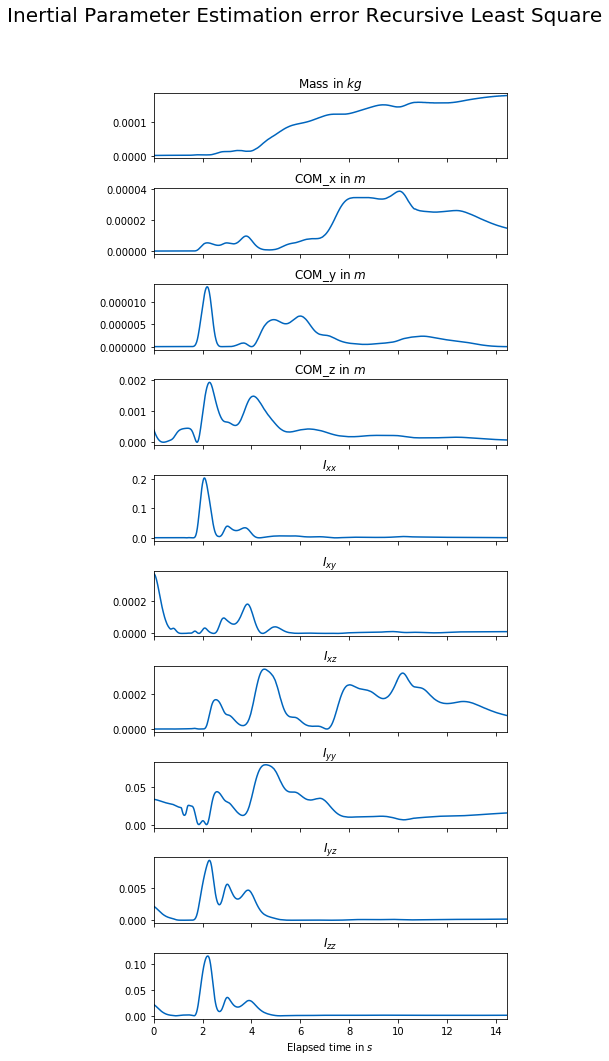

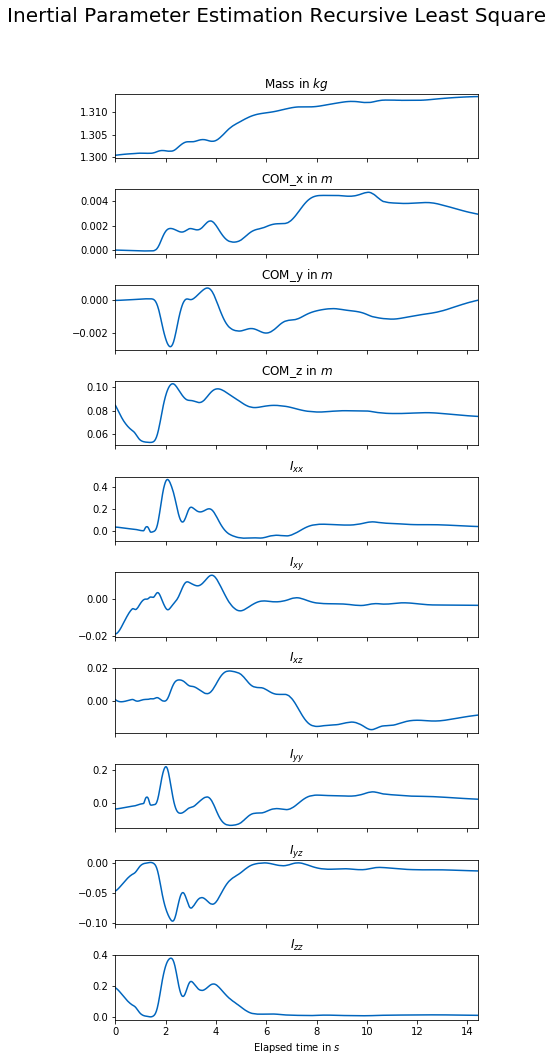

In [4]:
Plot_intertial_params_one_error (time, phi_RLS, "Recursive Least Square",1.3, 0.0 ,0.0, 0.09, 0.015, 0.0, 0.0, 0.15, 0.0, 0.04)
Plot_intertial_params_one(time, phi_RLS, "Recursive Least Square")

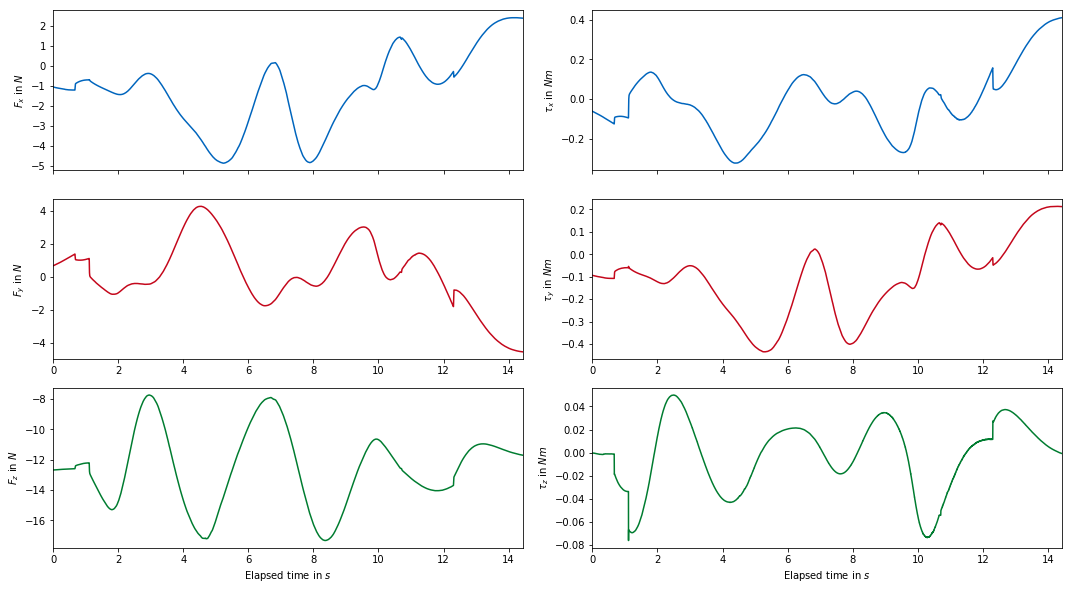

In [5]:
Plot_force_torque(time, force_virtual, torque_virtual)

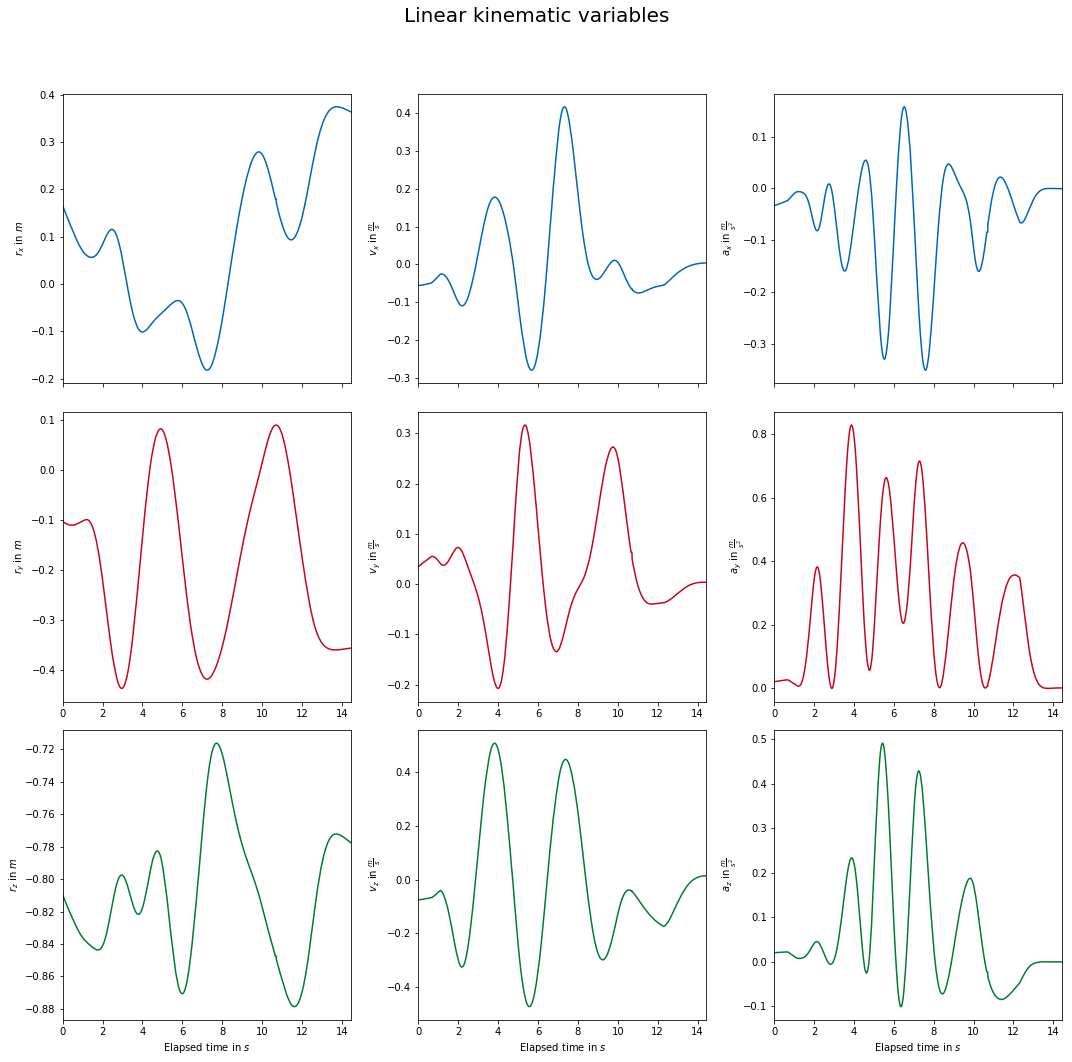

In [6]:
Plot_kinematics_linear(time, pos, vel, accel, "Linear kinematic variables")

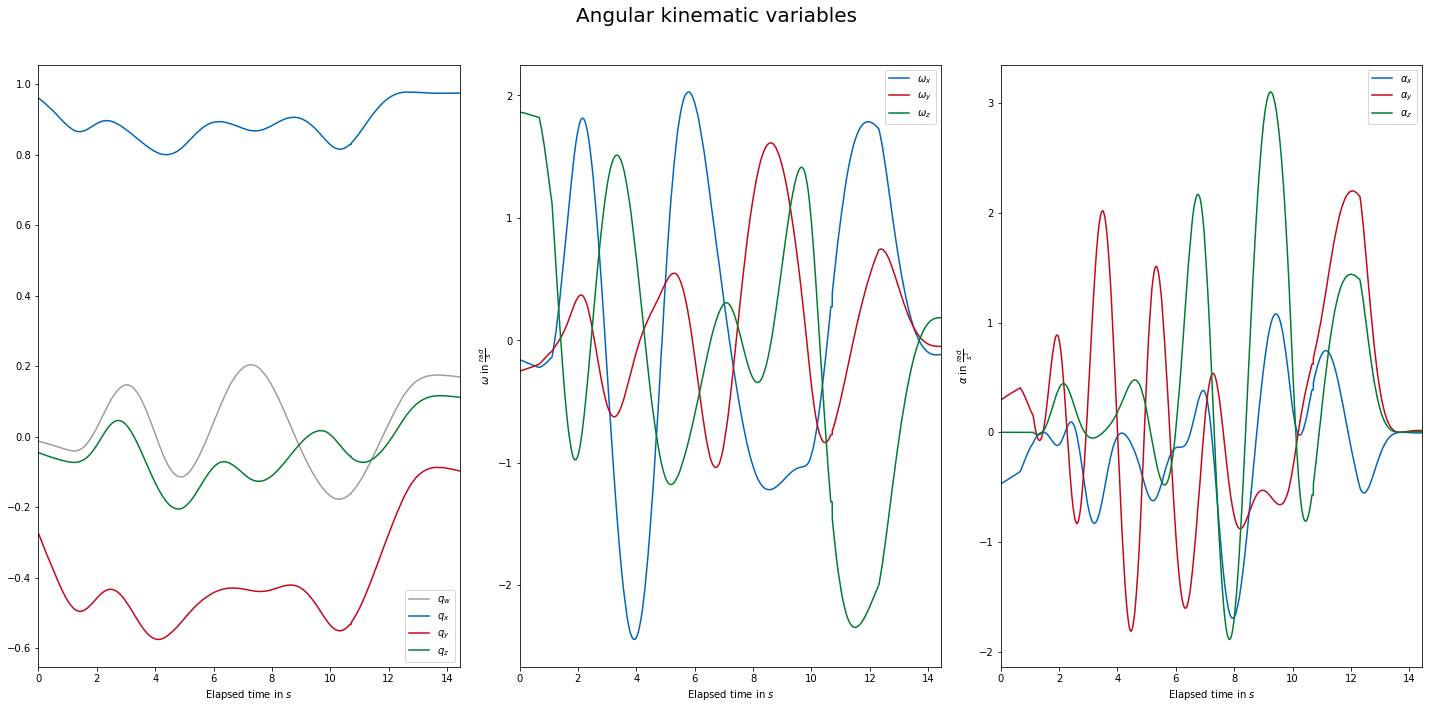

In [7]:
Plot_kinematics_angular_three_plots(time, ori, avel, aaccel, "Angular kinematic variables")

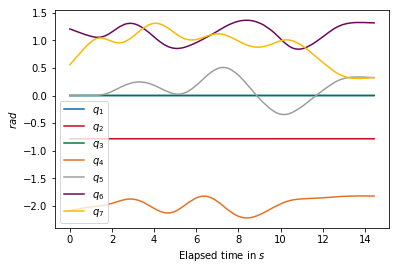

In [8]:
Plot_joint_angles(time, q, "Joint angles")

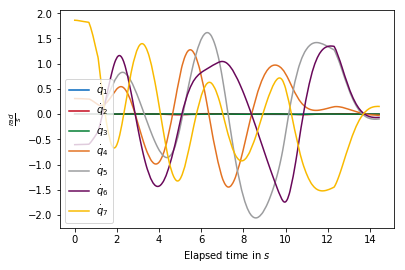

In [9]:
Plot_joint_velocities(time, dq, "Joint velocities")

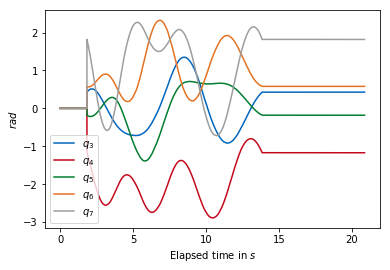

In [10]:
Plot_joint_angles_axis_five(time, q_des, "desired joint angles")

IndexError: index 2 is out of bounds for axis 1 with size 2

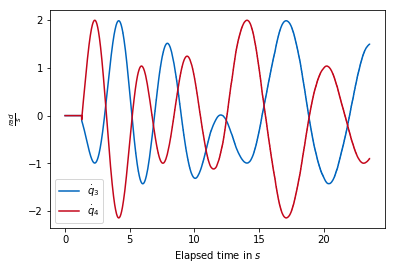

In [86]:
Plot_joint_velocities_axis_five(time, dq_des, "desired joint velocities")

In [34]:
def fourier_series(a, b, axis, N, w_f, q0, time):
    M_a = np.zeros(shape=(N, axis))
    M_b = np.zeros(shape=(N, axis))
    for i in np.arange(axis):
        for j in np.arange(N):
            M_a[j, i] = a[j+(i*2)]
            M_b[j, i] = b[j+(i*2)]
            
    arg = w_f * time
    arg_diff = w_f
    arg_diff_diff = w_f*w_f

    q = np.zeros(shape=(axis))
    dq = np.zeros(shape=(axis))
    ddq = np.zeros(shape=(axis))
    for i in np.arange(axis):
        q[i] = q0[i]
        for j in np.arange(N):
            q[i] += M_a[j,i] * np.sin(arg*(j+1)) + M_b[j,i] * np.cos(arg*(j+1))
            dq[i] += M_a[j,i] * arg_diff * (j+1) * np.cos(arg*(j+1)) - M_b[j,i] * arg_diff * (j+1) * np.sin(arg*(j+1))
            ddq[i] += - M_a[j,i] * arg_diff_diff * (j+1)*(j+1) * np.sin(arg*(j+1)) - M_b[j,i] * arg_diff_diff * (j+1)*(j+1) * np.cos(arg*(j+1))
            
    return q
def fourier(coeffs_a,coeffs_b,w_f, q0, time):
    q = q0
    for idx, (a, b) in enumerate(zip (coeffs_a, coeffs_b)):
        q += a * np.sin(w_f*time*(idx+1)) + b * np.cos(w_f*time*(idx+1))
    return q
def fourier_swevens(coeffs_a, coeffs_b, l_sums, w_f, q0, time):
    q = q0
    for (a, b, l) in zip (coeffs_a, coeffs_b, l_sums):
        q += a * np.sin(w_f*l*time) + b * np.cos(w_f*l*time)
    return q


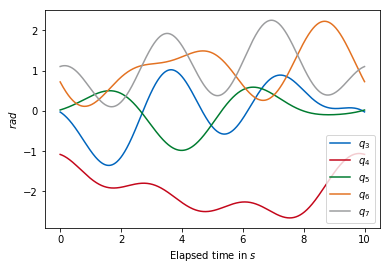

In [98]:
a = np.array([-0.384447  ,-0.549169 ,  0.234551 ,-0.0350113 , -0.187647   ,0.680153  -0.164255,   -0.16014 , -0.699964 , -0.228531,  -0.075119  ,  0.27301 , -0.320018 , -0.110771 ,-0.0350925])
b = np.array([ -0.306378 , -0.210935  ,   0.4905  , 0.227061 ,  0.209433 , -0.146835, -0.0387504 , 0.0323132 , -0.320253 , -0.285995 ,  0.662638 ,-0.0026003  , -0.43539 ,  0.134675,   0.185091])


axis = 5
N = 3 
T_s = 1/500.0
w_f = 0.628
q0 = np.array([ 0, -115, 0, 60, 60.0])
q0 *= np.pi/180.0
# t = np.arange(60, step = 0.01)
# q = fourier_series(a,b,axis,N, w_f, q0, t)
q = np.array([fourier_series(a,b,axis,N, w_f, q0, t) for t in np.arange(2*np.pi/w_f, step = 0.01)])
# q = np.array([fourier_series(a,b,axis,N, w_f, q0, t) for t in time])
Plot_joint_angles_axis_five(np.arange(2*np.pi/w_f, step = 0.01), q, "example")




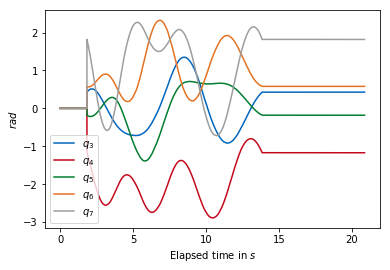

In [11]:
Plot_joint_angles_axis_five(time, q_des, "desired joint angles")


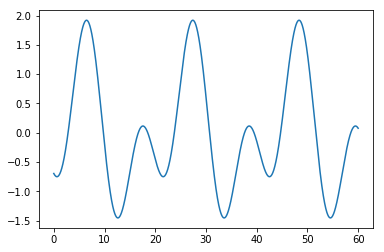

In [36]:
a = np.array([ 0.974478 , -0.769762])
b = np.array([-0.0587619 , -0.637884])
w_f = 0.3
q = np.array([fourier(a,b,w_f, 0, t) for t in time])
plt.plot(time,q)

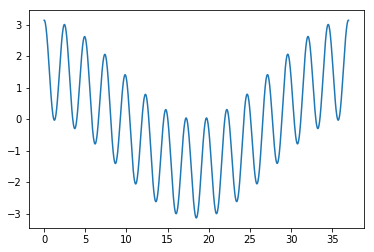

In [126]:
a = np.array([0,2.56e-2])
b = np.array([1.57, 1.57])
l = np.array([1,15])
w_f = 0.17
q0 = 0
T_s = 0.024
time = np.arange(37, step=T_s)
q = np.array([fourier_swevens(a, b, l, w_f, q0, k) for k in time])
plt.plot(time, q)
    

In [143]:
from constraint import *
problem = Problem()
problem.addVariable('a', range(-1,1))
problem.addVariable('b', range(-1,1))
problem.addConstraint(lambda a, b: a + b == 5)
problem.addConstraint(lambda a, b: a * b == 6)
problem.getSolutions()

[{'a': 3, 'b': 2}, {'a': 2, 'b': 3}]